<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Projeto 3 - Ciência dos Dados</p>

Alunos:
<ul style="font-family:monospace">
    <li>Cicero Tiago Carneiro Valentim</li>
    <li>Luiz Felipe Lazzaron</li>
    <li>Marcos Vinícius da Silva</li>
    <li>Thalia Loiola Silva</li>
</ul>

In [60]:
# pandas # (comentar)
import pandas as pd 
from pandas.tools.plotting import scatter_matrix 

# numpy # (comentar)
import numpy as np 

# matplotlib #(comentar)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

# (comentar)
import seaborn as sns

# time (calular tempo gasto nos modelos)
from time import time

# warnings (deixar de poluir o documento com warnings)
import warnings
warnings.filterwarnings('ignore')

# scikit-learn (comentar)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler, Imputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

# scikit-learn modelos (comentar)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# função utilizada para exibir os scores dos modelos
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# classe criada para auxiliar as transformações na pipeline
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

%matplotlib inline 

In [61]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

In [62]:
airbnb.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [63]:
# limpar colunas desnecessárias:
airbnb = airbnb.drop(columns=["id","name","host_name","minimum_nights","last_review", 'reviews_per_month', 'calculated_host_listings_count', 'host_id'])

In [64]:
# analisar a coluna "room_type", pois ela parece ser relevante para a análise
airbnb["room_type"].value_counts() # Essa coluna mostrou bastante potencial como variável qualitativa

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [65]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,355


### Separação em teste e treinamento

In [66]:
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(airbnb, airbnb["room_type"]):
#    strat_train_set = airbnb.loc[train_index] # x_train
#    strat_test_set = airbnb.loc[test_index] # x_test
#    y_test = airbnb["room_type"][test_index] #y_train

In [67]:
#strat_test_set.head(2)

In [68]:
#strat_train_set.head(2)

In [69]:
#airbnb = strat_train_set.drop("price", axis=1)  # df para treinamento
#airbnb_labels = strat_train_set["price"].copy() # "gabarito"

In [70]:
#airbnb_labels.head()

In [71]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,355


In [72]:
airbnb_labels = airbnb["price"].copy()

In [73]:
airbnb.shape, airbnb_labels.shape

((48895, 8), (48895,))

In [74]:
# where magic happens
num_attribs = list(airbnb.drop(columns=["neighbourhood_group","neighbourhood","room_type"]).columns)
cat_attribs = ["neighbourhood_group","neighbourhood","room_type"]

num_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(num_attribs) ),
    ('imputer', SimpleImputer(strategy="median")),
    ( 'std_scaler', StandardScaler() )
])
cat_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(cat_attribs) ),
    ( 'label_encoder', LabelEncoder())
])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
])

In [75]:
airbnb_prepared = full_pipeline.fit_transform(airbnb)

In [76]:
# separar em uma nova base de treinamento e teste:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(airbnb_prepared, airbnb_labels, test_size=0.33, random_state=RANDOM_SEED)

In [77]:
some_labels = airbnb_labels.iloc[:5]

In [78]:
some_data = airbnb.iloc[:5] # analise das 8 primeiras linhas

In [79]:
# preparação de some_data apenas para teste futuro
some_data_prepared = full_pipeline.transform(some_data)

<hr><p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace">K-Neighbors Regressor</p><hr>

Esse tipo de algoritmo pode ser utilizado tanto para classificações como para regressões. Nesse caso, como o próprio título já sugere, o modelo será focado em uma regressão, de tal forma que se consiga prever o preço de determinada residência tomando como base em uma medida de similaridade.

In [80]:
from sklearn.neighbors import KNeighborsRegressor
import mglearn 

De forma simplificada, esse modelo trabalhará da seguinte forma:

O "test prediction" mostrado abaixo refere-se a variável na qual se quer prever. Essa variável será prevista pela k-neighbors regressor com base nos pontos de treinamento próximos a ela. Para a escolha dos pontos, deve-se mudar o valor dado ao argumento "n_neighbors", visto no comando abaixo. 

Vale ressaltar, no entanto, que um valor alto dado para esse argumento não implica necessariamente em uma melhoria do modelo. Portanto, a escolha desse valor deve ser feita de forma criteriosa para que se possa chegar a melhor predição possível.

###### n_neighbors = 7

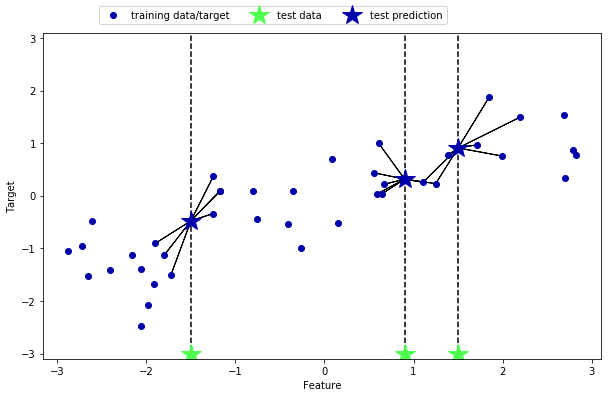

In [81]:
mglearn.plots.plot_knn_regression(n_neighbors=7)

###### n_neighbors = 3

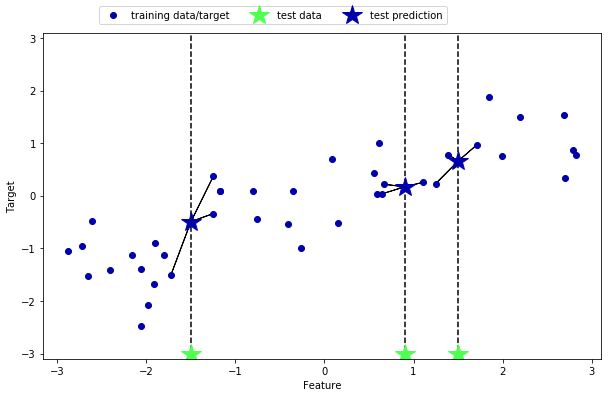

In [82]:
mglearn.plots.plot_knn_regression(n_neighbors=3);

In [83]:
k_reg = KNeighborsRegressor(n_neighbors=5)

In [84]:
k_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [85]:
print("Predictions:\t", list(k_reg.predict(some_data_prepared)))
print("Labels:\t\t", list(some_labels))

Predictions:	 [104.6, 224.8, 144.0, 128.8, 96.2]
Labels:		 [149, 225, 150, 89, 80]


Abaixo, a função .predict será utilizada para prever, com base no modelo que está sendo usado, os preços do novo banco de dados que foi preparado acima, chamado "airbnb_prepared".

In [86]:
airbnb_predictions = k_reg.predict(X_test)

In [93]:
r2 = r2_score(y_test, airbnb_predictions)
print("R² = {}".format(r2))

R² = 0.9753655802786794


In [92]:
time_init = time()

k_reg_scores = cross_val_score(k_reg, airbnb_prepared, airbnb_labels, cv=10)

print("\nTempo gasto: {:.2f} segundos".format(time() - time_init))


Tempo gasto: 229.37 segundos


In [94]:
k_reg_scores

array([0.98235499, 0.9870799 , 0.98006828, 0.98170868, 0.97059964,
       0.98547258, 0.98552021, 0.98226218, 0.98759549, 0.97861905])

In [95]:
display_scores(k_reg_scores)

Scores: [0.98235499 0.9870799  0.98006828 0.98170868 0.97059964 0.98547258
 0.98552021 0.98226218 0.98759549 0.97861905]
Mean: 0.9821280999748174
Standard deviation: 0.004762476730101714


In [96]:
sns.scatterplot(
    x='mean area',
    y='mean compactness',
    hue='benign',
    data=X_test.join(y_test, how='outer')
)

AttributeError: join not found

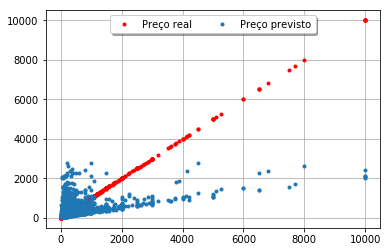

In [32]:
ax = plt.subplot(111)
plt.plot(airbnb_labels, airbnb_labels, 'r.', label='Preço real')
plt.plot(airbnb_labels, airbnb_predictions, '.', label='Preço previsto')
plt.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.show()

AttributeError: Unknown property figsize

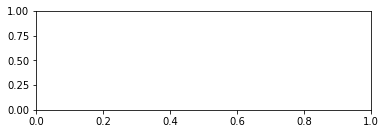

In [34]:
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = airbnb_predictions

    plt.subplot(2, 1, i + 1)
    plt.scatter(airbnb_labels, airbnb_labels, c='k', label='data')
    plt.plot(airbnb_labels, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.tight_layout()

plt.show()